## Summary
#### Dataset
* This dataset tries to capture customer purchase behavior in __baby__ category. 
* This dataset includes __100__ mother users from the mother cluster, resulting from K-means clustering based on purchase history.
* The K-means clustering was performed on top __20%__ users of year 2017.
* For each dataset, datapoint was sampled at uniform time interval (7 days).
* For each sampled reference time, the sample is labelled __1__ if user placed an order in __baby__ category within __7 days__. Otherwise it's labelled __0__.

#### Features
- [x] Exponential moving averages of aggregate spending (ema)
- [o] Average days between orders (dpo)
- [x] Average days per quantity purchased (dpq)
- [o] Days since last purchase in all categories (dsl)
- [x] Average browse between consecutive purchases in all categories (bpo, bpo_e)
- [x] Average browse per quantity purchased (bpq)
- [x] Browse since most recent purchase (bsl)
- [x] Average GMV per day between consecutive purchases (gpo, gpo_e)
- [x] GMV / order (gpo)
- [x] GMV / quantity (gpq)
- [x] GMV / day = (GMV / order) / (day / order) (gpd)
- [x] GMV per day since most recent purchase in category (gsl)

#### Model
* 3-Layered Neural Net
* See def Build_Model() for details
* __Only 2 features are included__: days per order (gpo), days since last order (dsl)

#### Performance
* baseline = 0.59217
* True positive(tp) = 77
* True negative(tn) = 213
* False positive(fp) = 44
* False negative(fn) = 100
* precision = 0.63636
* recall = 0.43503
* accuracy = 0.66820
* True Positive Rate(TPR) = 0.43503
* False Positive Rate(FPR) = 0.17121

In [1]:
%run -i 'py/load_libraries.py'

## Load Dataset

In [2]:
file_prefix = "sl_2017_18_jul_baby_dsl_dpo"
sub_dir = "data"

In [3]:
path = os.path.join(cwd, sub_dir, file_prefix + ".csv")
df = pd.read_csv(path, sep = ",")

print(df.shape)

(70568, 6)


In [4]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans(df).shape

(0, 6)

In [5]:
df_inspect = pd.DataFrame(columns = df.columns.insert(0, "note"))

min_ = np.min(df, axis = 0)
min_["note"] = "min"
df_inspect = df_inspect.append(min_, ignore_index=True)

pct_25 = {df.columns[i] : np.percentile(df, 25, axis = 0)[i] for i in range(len(np.percentile(df, 25, axis = 0)))}
pct_25["note"] = "pct_25"
df_inspect = df_inspect.append(pct_25, ignore_index=True)

pct_50 = {df.columns[i] : np.percentile(df, 50, axis = 0)[i] for i in range(len(np.percentile(df, 25, axis = 0)))}
pct_50["note"] = "pct_50"
df_inspect = df_inspect.append(pct_50, ignore_index=True)

pct_75 = {df.columns[i] : np.percentile(df, 75, axis = 0)[i] for i in range(len(np.percentile(df, 25, axis = 0)))}
pct_75["note"] = "pct_75"
df_inspect = df_inspect.append(pct_75, ignore_index=True)

max_ = np.max(df, axis = 0)
max_["note"] = "max"
df_inspect = df_inspect.append(max_, ignore_index=True)

mu_ = np.mean(df, axis = 0)
mu_["note"] = "mean"
df_inspect = df_inspect.append(mu_, ignore_index=True)

std_ = np.std(df, axis = 0)
std_["note"] = "std"
df_inspect = df_inspect.append(std_, ignore_index=True)

nan = {df.columns[i] : len(nans(df[[df.columns[i]]])) * 100 / len(df) for i in range(len(df.columns))}
nan["note"] = "nan"
df_inspect = df_inspect.append(nan, ignore_index=True)

inf = {df.columns[i] : len(df[np.isinf(df[df.columns[i]])]) * 100 / len(df) for i in range(len(df.columns))}
inf["note"] = "inf"
df_inspect = df_inspect.append(inf, ignore_index=True)

In [6]:
df_inspect.set_index("note").T

note,min,pct_25,pct_50,pct_75,max,mean,std,nan,inf
member_srl,16953.0,6820587.00,23571707.0,75631849.00,113113444.0,4.125107e+07,4.014887e+07,0.0,0.0
ref_dt,20170707.0,20171107.00,20180122.0,20180407.00,20180622.0,2.017633e+07,4.627944e+03,0.0,0.0
rct_dt,20170701.0,20170918.00,20171210.0,20180303.00,20180622.0,2.017504e+07,4.642598e+03,0.0,0.0
dsl,0.0,6.00,18.0,45.00,351.0,3.479024e+01,4.457474e+01,0.0,0.0
dpo,0.0,4.75,13.3,23.75,157.5,1.687939e+01,1.672651e+01,0.0,0.0
label,0.0,0.00,0.0,1.00,1.0,4.094065e-01,4.917243e-01,0.0,0.0


## Preprocessing

In [7]:
# drop bad features here
df = df.drop([key_srl, "ref_dt", "rct_dt"], axis = 1)

In [8]:
df = df.dropna()
print(df.shape)

(70568, 3)


In [9]:
# separate label into another dataframe
df_labl = df[[key_label]]
df_labl.head()

,label
0,0
1,0
2,0
3,0
4,1


In [10]:
# extract input features
df_data = df.drop([key_label], axis = 1)
df_data.head()

,dsl,dpo
0,7,0.5
1,22,0.5
2,38,0.5
3,53,0.5
4,68,0.5


## Gradient Boosting Machine 
* Rank features by importance
* Apply to entire dataset

In [11]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [12]:
def modelfit(alg, dtrain, labels, predictors, performCV = True, printFeatureImportance = True, cv_folds = 5):
    #Fit the algorithm on the data
    alg.fit(dtrain, labels)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, 
                                                    dtrain, 
                                                    labels, 
                                                    cv=cv_folds, 
                                                    scoring='accuracy')
    
    #Print model report:
    analysis.log("\nModel Report")
    analysis.log("Accuracy : %.10g" % metrics.accuracy_score(labels, dtrain_predictions))
    analysis.log("AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob))
    
    if performCV:
        analysis.log("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g\n" % (np.mean(cv_score),
                                                                                 np.std(cv_score),
                                                                                 np.min(cv_score),
                                                                                 np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.savefig(os.path.join(cwd, "fig", "feature_importance.png"))

In [13]:
predictors = [x for x in df_data.columns if x not in [key_label, key_dt]]
gbm0 = GradientBoostingClassifier(random_state=10)


Model Report
Accuracy : 0.6728970638
AUC Score (Train): 0.711036
CV Score : Mean - 0.6713809 | Std - 0.003380754 | Min - 0.6658874 | Max - 0.6761851



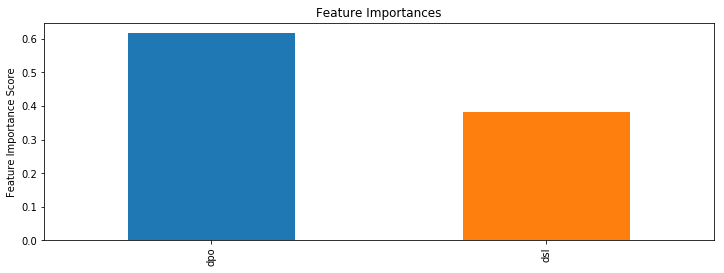

In [14]:
modelfit(gbm0, df_data, df_labl.values.reshape(df_labl.shape[0], ), predictors)

## Build Train-Test Dataset

In [15]:
# choose subset of features to use
features = ["dpo", "dsl"]

# choose train-test split ratio
ratio = 0.9

In [16]:
# normalize
df_data = (df_data - np.mean(df_data)) / np.std(df_data)

In [17]:
df_data = df[features]

df_data.head()
df_data.shape

(70568, 2)

In [18]:
rows = len(df_data)
split = int(rows * ratio)
trn_data = df_data[:split]
trn_labl = df_labl[:split].astype(int)

tst_data = df_data[split:]
tst_labl = df_labl[split:].astype(int)

## Baseline

In [19]:
print("Dataset baseline: %.5f%%"%(analysis.Baseline(df_labl)))
print("Train baseline: %.5f%%"%(analysis.Baseline(trn_labl)))
print("Test baseline: %.5f%%"%(analysis.Baseline(tst_labl)))

Dataset baseline: 59.05935%
Train baseline: 59.32516%
Test baseline: 56.66714%


## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE

In [21]:
logreg = LogisticRegression(max_iter = 10000,
                           verbose = 3)
logreg.fit(trn_data, 
           trn_labl)

[LibLinear]

/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False)

In [22]:
logreg.score(tst_data, 
             tst_labl, 
             sample_weight=None)

0.60861555901941333

In [23]:
pred = logreg.predict(tst_data)
_ = deepcopy(tst_labl)
_["pred"] = pred
_.T

,63511,63512,63513,63514,63515,63516,63517,63518,63519,63520,...,70558,70559,70560,70561,70562,70563,70564,70565,70566,70567
label,0,0,0,0,1,1,0,1,0,0,...,0,1,1,1,1,0,1,1,1,1
pred,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1


In [24]:
np.sum(pred)

1610

## Neural Net Binary Classifier

In [25]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.utils import np_utils

Using TensorFlow backend.


In [26]:
def Build_Model():
    nn = Sequential()
    nn.add(Dense(32, activation="relu", input_shape=(len(features),)))
    nn.add(Dense(32, activation="relu"))
    nn.add(Dense(1, activation="sigmoid"))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return nn

In [27]:
nn = Build_Model()
nn.fit(trn_data, trn_labl, epochs = 10, batch_size = 512)

Epoch 1/10
63511/63511 [==============================] - 0s 5us/step - loss: 0.6634 - acc: 0.6055
Epoch 2/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6382 - acc: 0.6561
Epoch 3/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6306 - acc: 0.6691
Epoch 4/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6252 - acc: 0.6668
Epoch 5/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6227 - acc: 0.6687
Epoch 6/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6221 - acc: 0.6665
Epoch 7/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6204 - acc: 0.6686
Epoch 8/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6192 - acc: 0.6681
Epoch 9/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6204 - acc: 0.6698
Epoch 10/10
63511/63511 [==============================] - 0s 4us/step - loss: 0.6186 - acc: 0.6699


In [28]:
pred_prob = nn.predict_proba(tst_data)
_ = deepcopy(tst_labl)
_["pred"] = pred_prob
_.T

,63511,63512,63513,63514,63515,63516,63517,63518,63519,63520,...,70558,70559,70560,70561,70562,70563,70564,70565,70566,70567
label,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,...,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0000,1.000000
pred,0.319144,0.330433,0.284078,0.292116,0.287584,0.255347,0.294975,0.31062,0.297811,0.317674,...,0.707282,0.58846,0.622595,0.692572,0.689314,0.669001,0.642383,0.516354,0.4439,0.693456


In [29]:
_[_[key_label] == 1].T

,63515,63516,63518,63522,63524,63539,63542,63544,63547,63552,...,70556,70557,70559,70560,70561,70562,70564,70565,70566,70567
label,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000
pred,0.287584,0.255347,0.31062,0.197118,0.516243,0.232235,0.592342,0.559239,0.419286,0.299536,...,0.392116,0.696636,0.58846,0.622595,0.692572,0.689314,0.642383,0.516354,0.4439,0.693456


In [30]:
pred = nn.predict(tst_data)
_ = deepcopy(tst_labl)
_["pred_p"] = pred
_["pred"] = pred > 0.5
_.T

,63511,63512,63513,63514,63515,63516,63517,63518,63519,63520,...,70558,70559,70560,70561,70562,70563,70564,70565,70566,70567
label,0,0,0,0,1,1,0,1,0,0,...,0,1,1,1,1,0,1,1,1,1
pred_p,0.319144,0.330433,0.284078,0.292116,0.287584,0.255347,0.294975,0.31062,0.297811,0.317674,...,0.707282,0.58846,0.622595,0.692572,0.689314,0.669001,0.642383,0.516354,0.4439,0.693456
pred,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,False,True


In [31]:
np.sum(tst_labl == (pred > 0.5)) / len(tst_labl)

label    0.661329
dtype: float64

## Neural Net Cross Validation

In [32]:
k = 4
num_val_samples = len(trn_data) // k
num_epochs = 200
batch_size = 256
all_scores = []
all_val_loss_history = []
all_val_acc_history = []

for i in range(k):
    print('processing fold %i'%(i + 1), end="\r")
    val_data = trn_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_labl = trn_labl[i * num_val_samples : (i + 1) * num_val_samples]
    
    prt_trn_data = np.concatenate([trn_data[:i * num_val_samples],
                                  trn_data[(i + 1) * num_val_samples:]], axis = 0)
    prt_trn_labl = np.concatenate([trn_labl[:i * num_val_samples],
                                  trn_labl[(i + 1) * num_val_samples:]], axis = 0)
    
    model = Build_Model()
    history = model.fit(prt_trn_data, prt_trn_labl, 
                        validation_data = (val_data, val_labl),
                        epochs = num_epochs, batch_size = batch_size, verbose = 0)
    
    all_val_loss_history.append(history.history['val_loss'])
    all_val_acc_history.append(history.history['val_acc'])
    
    val_l, val_a = model.evaluate(val_data, val_labl, verbose = 0)
    print("Fold %i val_loss %.5f, val_acc %.5f"%(i + 1, val_l, val_a))
    all_scores.append(val_a)

Fold 1 val_loss 0.62114, val_acc 0.66052
Fold 2 val_loss 0.60651, val_acc 0.67897
Fold 3 val_loss 0.60868, val_acc 0.67563
Fold 4 val_loss 0.60724, val_acc 0.67777


In [33]:
avg_val_loss_hist = [np.mean([x[i] for x in all_val_loss_history]) for i in range(num_epochs)]
avg_val_acc_hist = [np.mean([x[i] for x in all_val_acc_history]) for i in range(num_epochs)]

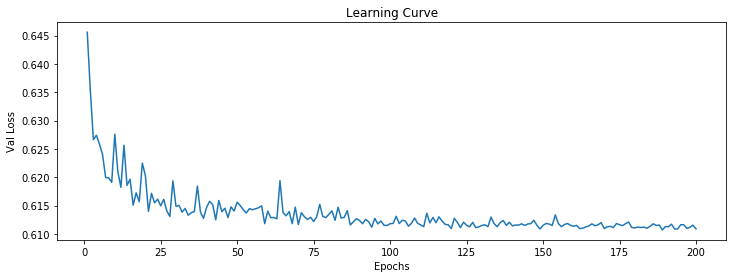

In [34]:
plt.plot(range(1, len(avg_val_loss_hist) + 1), avg_val_loss_hist)
plt.xlabel("Epochs")
plt.ylabel("Val Loss")
plt.title("Learning Curve")
plt.savefig(os.path.join(cwd, "fig", "learning_curve.png"))
plt.show()

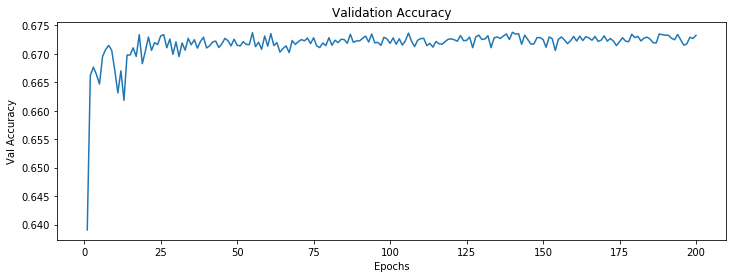

In [35]:
plt.plot(range(1, len(avg_val_acc_hist) + 1), avg_val_acc_hist)
plt.xlabel("Epochs")
plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy")
plt.savefig(os.path.join(cwd, "fig", "validation_accuracy.png"))
plt.show()

## Final Model

In [36]:
num_epochs = 120
batch_size = 256
threshold = 0.45
model = Build_Model()
history = model.fit(trn_data, trn_labl,
                    validation_data = (tst_data, tst_labl),
                    epochs = num_epochs, batch_size = batch_size, verbose = 0)

In [37]:
pred = model.predict(tst_data)
_ = deepcopy(tst_labl)
_["pred_p"] = pred
_["pred"] = pred > threshold
_.T

,63511,63512,63513,63514,63515,63516,63517,63518,63519,63520,...,70558,70559,70560,70561,70562,70563,70564,70565,70566,70567
label,0,0,0,0,1,1,0,1,0,0,...,0,1,1,1,1,0,1,1,1,1
pred_p,0.30734,0.312895,0.29298,0.282305,0.299446,0.290069,0.301114,0.306443,0.306796,0.313111,...,0.805321,0.66649,0.659006,0.792471,0.787531,0.740066,0.644583,0.569208,0.458372,0.6993
pred,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [38]:
_[_[key_label] == 1].T

,63515,63516,63518,63522,63524,63539,63542,63544,63547,63552,...,70556,70557,70559,70560,70561,70562,70564,70565,70566,70567
label,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
pred_p,0.299446,0.290069,0.306443,0.221226,0.482009,0.264554,0.608779,0.509348,0.405354,0.311904,...,0.412018,0.712906,0.66649,0.659006,0.792471,0.787531,0.644583,0.569208,0.458372,0.6993
pred,False,False,False,False,True,False,True,True,False,False,...,False,True,True,True,True,True,True,True,True,True


In [39]:
_[_[key_label] == 0].T

,63511,63512,63513,63514,63517,63519,63520,63521,63523,63525,...,70524,70525,70530,70535,70541,70542,70553,70555,70558,70563
label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pred_p,0.30734,0.312895,0.29298,0.282305,0.301114,0.306796,0.313111,0.273799,0.548318,0.423796,...,0.470413,0.414073,0.742082,0.723911,0.28015,0.219887,0.692302,0.680012,0.805321,0.740066
pred,False,False,False,False,False,False,False,False,True,False,...,True,False,True,True,False,False,True,True,True,True


## Analysis

In [40]:
summary = analysis.err_analyze(tst_labl.values, pred, threshold, verbose = True)

baseline = 56.66714%
tp = 1801
tn = 2875
fp = 1124
fn = 1257
precision = 61.57265%
recall = 58.89470%
accuracy = 66.26045%
TPR = 58.89470%
FPR = 28.10703%


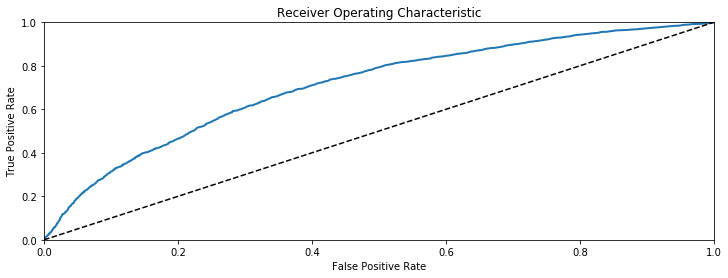

In [41]:
tprs, fprs, ts = analysis.discretize(tst_labl.values, pred, n = 1000)
analysis.plot_roc_curve(fprs, tprs, save_path = os.path.join(cwd, "fig", "roc.png"))

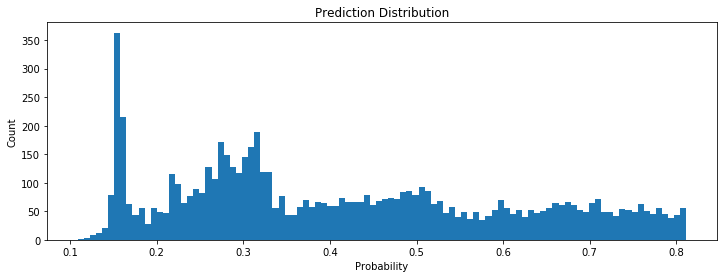

In [42]:
plt.hist(pred, 100)
plt.title("Prediction Distribution")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.savefig(os.path.join(cwd, "fig", "predict_prob.png"))